In [ ]:
!pip install xgboost
!pip install numpy pandas scikit-learn keras xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFE, SelectFromModel, RFECV, SelectKBest, f_classif, VarianceThreshold, mutual_info_classif
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [ ]:
file_path='/content/drive/MyDrive/combined_wind_farm_A_data_new.csv'
data=pd.read_csv(file_path, delimiter=',', encoding='utf-8', on_bad_lines='skip')
print("File loaded successfully!")

File loaded successfully!


In [ ]:
data.columns

Index(['time_stamp', 'asset_id', 'id', 'train_test', 'status_type_id',
       'sensor_0_avg', 'sensor_1_avg', 'sensor_2_avg', 'wind_speed_3_avg',
       'wind_speed_4_avg', 'wind_speed_3_max', 'wind_speed_3_min',
       'wind_speed_3_std', 'sensor_5_avg', 'sensor_5_max', 'sensor_5_min',
       'sensor_5_std', 'sensor_6_avg', 'sensor_7_avg', 'sensor_8_avg',
       'sensor_9_avg', 'sensor_10_avg', 'sensor_11_avg', 'sensor_12_avg',
       'sensor_13_avg', 'sensor_14_avg', 'sensor_15_avg', 'sensor_16_avg',
       'sensor_17_avg', 'sensor_18_avg', 'sensor_18_max', 'sensor_18_min',
       'sensor_18_std', 'sensor_19_avg', 'sensor_20_avg', 'sensor_21_avg',
       'sensor_22_avg', 'sensor_23_avg', 'sensor_24_avg', 'sensor_25_avg',
       'sensor_26_avg', 'reactive_power_27_avg', 'reactive_power_27_max',
       'reactive_power_27_min', 'reactive_power_27_std',
       'reactive_power_28_avg', 'reactive_power_28_max',
       'reactive_power_28_min', 'reactive_power_28_std', 'power_29_avg',
      

In [ ]:
data['event_description'].unique()

array(['Generator bearing failure', 'Gearbox failure', 'Normal',
       'Hydraulic group', ' Normal ', 'Transformer failure', ' Normal'],
      dtype=object)

In [ ]:
# Replace 0 and 2 with 0, and others with 1
data['event_description'] = data['event_description'].replace({' Normal': 0, ' Normal ': 0, 'Normal' : 0, 'Generator bearing failure' : 1, 'Gearbox failure': 2, 'Hydraulic group': 3, 'Transformer failure' : 4})

print(data['event_description'].value_counts())


event_description
0    601394
3    322177
1    111144
2    107674
4     54358
Name: count, dtype: int64


<ipython-input-6-baac82c0364c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['event_description'] = data['event_description'].replace({' Normal': 0, ' Normal ': 0, 'Normal' : 0, 'Generator bearing failure' : 1, 'Gearbox failure': 2, 'Hydraulic group': 3, 'Transformer failure' : 4})


In [ ]:
print(data['status_type_id'].value_counts())
print(data['asset_id'].value_counts())
print(data['id'].value_counts())

status_type_id
0    898672
5    260387
3     23689
4     13999
Name: count, dtype: int64
asset_id
10    274213
0     272477
11    217950
13    216543
21    215564
Name: count, dtype: int64
id
0        22
35362    22
35352    22
35353    22
35354    22
         ..
55711     1
55712     1
55713     1
55714     1
56157     1
Name: count, Length: 56158, dtype: int64


In [ ]:
#Renaming the columns
rename_mapping = {
    'time_stamp': 'time_stamp',
    'asset_id': 'asset_id',
    'id': 'id',
    'train_test': 'train_test',
    'status_type_id': 'status_type_id',
    'sensor_0_avg': 'Ambient temperature avg',
    'sensor_1_avg': 'Wind absolute direction avg',
    'sensor_2_avg': 'Wind relative direction avg',
    'wind_speed_3_avg': 'Windspeed avg',
    'wind_speed_4_avg': 'Estimated windspeed avg',
    'wind_speed_3_max': 'Windspeed max',
    'wind_speed_3_min': 'Windspeed min',
    'wind_speed_3_std': 'Windspeed std',
    'sensor_5_avg': 'Pitch angle avg',
    'sensor_5_max': 'Pitch angle max',
    'sensor_5_min': 'Pitch angle min',
    'sensor_5_std': 'Pitch angle std',
    'sensor_6_avg': 'Hub controller temperature avg',
    'sensor_7_avg': 'Top nacelle controller temperature avg',
    'sensor_8_avg': 'Choke coils on the VCS- section temperature avg',
    'sensor_9_avg': 'VCP-board temperature avg',
    'sensor_10_avg': 'VCS cooling water temperature avg',
    'sensor_11_avg': 'Gearbox bearing on high speed shaft  temperature avg',
    'sensor_12_avg': 'Gearbox oil temperature avg',
    'sensor_13_avg': 'Generator bearing 2(Drive end)  temperature avg',
    'sensor_14_avg': 'Generator bearing 1(Non-drive end) temperature avg',
    'sensor_15_avg': 'Generator stator winding phase 1 temperature avg',
    'sensor_16_avg': 'Generator stator winding phase 2 temperature avg',
    'sensor_17_avg': 'Generator stator winding phase 3 temperature avg',
    'sensor_18_avg': 'Generator rpm avg',
    'sensor_18_max': 'Generator rpm max',
    'sensor_18_min': 'Generator rpm min',
    'sensor_18_std': 'Generator rpm std',
    'sensor_19_avg': 'Split ring chamber temperature avg',
    'sensor_20_avg': 'Busbar section temperature avg',
    'sensor_21_avg': 'IGBT-driver on grid side inverter temperature avg',
    'sensor_22_avg': 'Actual Phase displacement avg',
    'sensor_23_avg': 'Averaged current phase 1',
    'sensor_24_avg': 'Averaged current phase 2',
    'sensor_25_avg': 'Averaged current phase 3',
    'sensor_26_avg': 'Grid frequency',
    'reactive_power_27_avg': 'Possible Grid capacitive reactive power avg',
    'reactive_power_27_max': 'Possible Grid capacitive reactive power max',
    'reactive_power_27_min': 'Possible Grid capacitive reactive power min',
    'reactive_power_27_std': 'Possible Grid capacitive reactive power std',
    'reactive_power_28_avg': 'Possible Grid inductive reactive power avg',
    'reactive_power_28_max': 'Possible Grid inductive reactive power max',
    'reactive_power_28_min': 'Possible Grid inductive reactive power min',
    'reactive_power_28_std': 'Possible Grid inductive reactive power std',
    'power_29_avg': 'Possible Grid active power avg',
    'power_29_max': 'Possible Grid active power max',
    'power_29_min': 'Possible Grid active power min',
    'power_29_std': 'Possible Grid active power std',
    'power_30_avg': 'Grid power avg',
    'power_30_max': 'Grid power max',
    'power_30_min': 'Grid power min',
    'power_30_std': 'Grid power std',
    'sensor_31_avg': 'Grid reactive power avg',
    'sensor_31_max': 'Grid reactive power max',
    'sensor_31_min': 'Grid reactive power min',
    'sensor_31_std': 'Grid reactive power std',
    'sensor_32_avg': 'Averaged voltage phase 1',
    'sensor_33_avg': 'Averaged voltage phase 2',
    'sensor_34_avg': 'Averaged voltage phase 3',
    'sensor_35_avg': 'IGBT-driver on rotor side inverter phase 1 temperature avg',
    'sensor_36_avg': 'IGBT-driver on rotor side inverter phase 2 temperature avg',
    'sensor_37_avg': 'IGBT-driver on rotor side inverter phase 3 temperature avg',
    'sensor_38_avg': 'HV transformer phase L1 temperature avg',
    'sensor_39_avg': 'HV transformer phase L2 temperature avg',
    'sensor_40_avg': 'HV transformer phase L3 temperature avg',
    'sensor_41_avg': 'Hydraulic group oil temperature avg',
    'sensor_42_avg': 'Nacelle direction avg',
    'sensor_43_avg': 'Nacelle temperature avg',
    'sensor_44': 'Generator disconnected active power avg',
    'sensor_45': 'Generator connected in delta active power avg',
    'sensor_46': 'Generator connected in star active power avg',
    'sensor_47': 'Generator disconnected reactive power avg',
    'sensor_48': 'Generator connected in delta reactive power avg',
    'sensor_49': 'Generator connected in star reactive power avg',
    'sensor_50': 'Total active power avg',
    'sensor_51': 'Total reactive power avg',
    'sensor_52_avg': 'Rotor rpm avg',
    'sensor_52_max': 'Rotor rpm max',
    'sensor_52_min': 'Rotor rpm min',
    'sensor_52_std': 'Rotor rpm std',
    'sensor_53_avg': 'Nose cone temperature avg',
}

# Rename the columns in the DataFrame
data.rename(columns=rename_mapping, inplace=True)
# Convert time to python date time format
data['time_stamp']=pd.to_datetime(data['time_stamp'])
#Converting object dtypes to strings
data=data.astype({col: 'string' for col in data.select_dtypes(include='object').columns})

In [ ]:
#Handling missing values
data=data.dropna()
missing_data=data.isnull().sum()
print("Missing values: \n", missing_data[missing_data>0])

Missing values: 
 Series([], dtype: int64)


In [ ]:
data=data.drop(['id', 'train_test', 'event_id', 'time_stamp', 'event_label'], axis=1)

In [ ]:
# Remove columns that contain 'min', 'max', or 'std'
filtered_columns = [col for col in data.columns if not any(keyword in col for keyword in ['min', 'max', 'std'])]
data_avg = data[filtered_columns]


In [ ]:
data.columns

Index(['asset_id', 'status_type_id', 'Ambient temperature avg',
       'Wind absolute direction avg', 'Wind relative direction avg',
       'Windspeed avg', 'Estimated windspeed avg', 'Windspeed max',
       'Windspeed min', 'Windspeed std', 'Pitch angle avg', 'Pitch angle max',
       'Pitch angle min', 'Pitch angle std', 'Hub controller temperature avg',
       'Top nacelle controller temperature avg',
       'Choke coils on the VCS- section temperature avg',
       'VCP-board temperature avg', 'VCS cooling water temperature avg',
       'Gearbox bearing on high speed shaft  temperature avg',
       'Gearbox oil temperature avg',
       'Generator bearing 2(Drive end)  temperature avg',
       'Generator bearing 1(Non-drive end) temperature avg',
       'Generator stator winding phase 1 temperature avg',
       'Generator stator winding phase 2 temperature avg',
       'Generator stator winding phase 3 temperature avg', 'Generator rpm avg',
       'Generator rpm max', 'Generator rpm 

In [ ]:
data_avg.columns

Index(['status_type_id', 'Ambient temperature avg',
       'Wind absolute direction avg', 'Wind relative direction avg',
       'Windspeed avg', 'Estimated windspeed avg', 'Pitch angle avg',
       'Hub controller temperature avg',
       'Top nacelle controller temperature avg',
       'Choke coils on the VCS- section temperature avg',
       'VCP-board temperature avg', 'VCS cooling water temperature avg',
       'Gearbox bearing on high speed shaft  temperature avg',
       'Gearbox oil temperature avg',
       'Generator bearing 2(Drive end)  temperature avg',
       'Generator bearing 1(Non-drive end) temperature avg',
       'Generator stator winding phase 1 temperature avg',
       'Generator stator winding phase 2 temperature avg',
       'Generator stator winding phase 3 temperature avg', 'Generator rpm avg',
       'Split ring chamber temperature avg', 'Busbar section temperature avg',
       'IGBT-driver on grid side inverter temperature avg',
       'Actual Phase displaceme

In [ ]:
data_avg.shape

(1196727, 57)

In [ ]:
data.shape

(1196727, 84)

Explained Variance Ratio per Component: [0.52214243 0.09834276 0.07901652 0.04963011 0.03186671 0.02770703
 0.02322178 0.01980814 0.01607138 0.01448679 0.01273674 0.01209762
 0.01171067 0.01078652 0.00854521 0.00732392 0.00568569 0.00512879
 0.00416133 0.00358385 0.00339718 0.00302885 0.0027007  0.00245463
 0.00220913 0.00205461 0.00172324 0.00161533 0.00158116 0.00144414]
Cumulative Explained Variance: [0.52214243 0.62048519 0.6995017  0.74913182 0.78099852 0.80870555
 0.83192733 0.85173547 0.86780685 0.88229364 0.89503038 0.907128
 0.91883866 0.92962518 0.93817039 0.94549431 0.95118    0.95630879
 0.96047012 0.96405397 0.96745115 0.97048    0.9731807  0.97563533
 0.97784445 0.97989907 0.9816223  0.98323763 0.9848188  0.98626294]


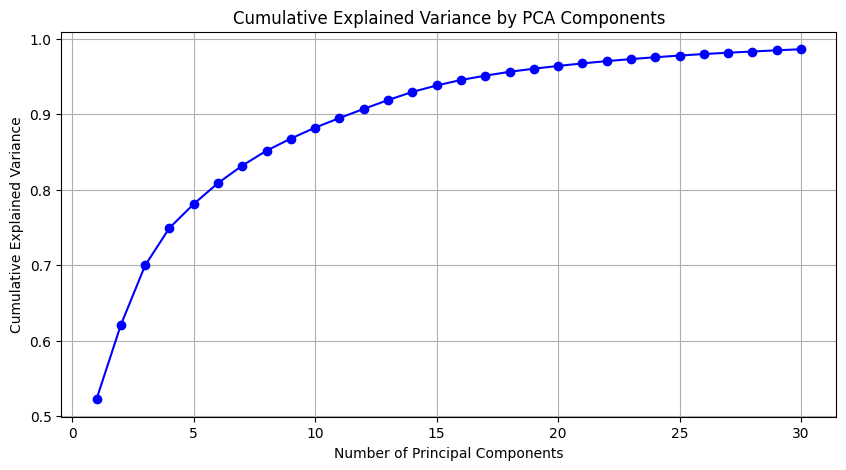

Reconstruction Error (MSE): 0.013397874537115401


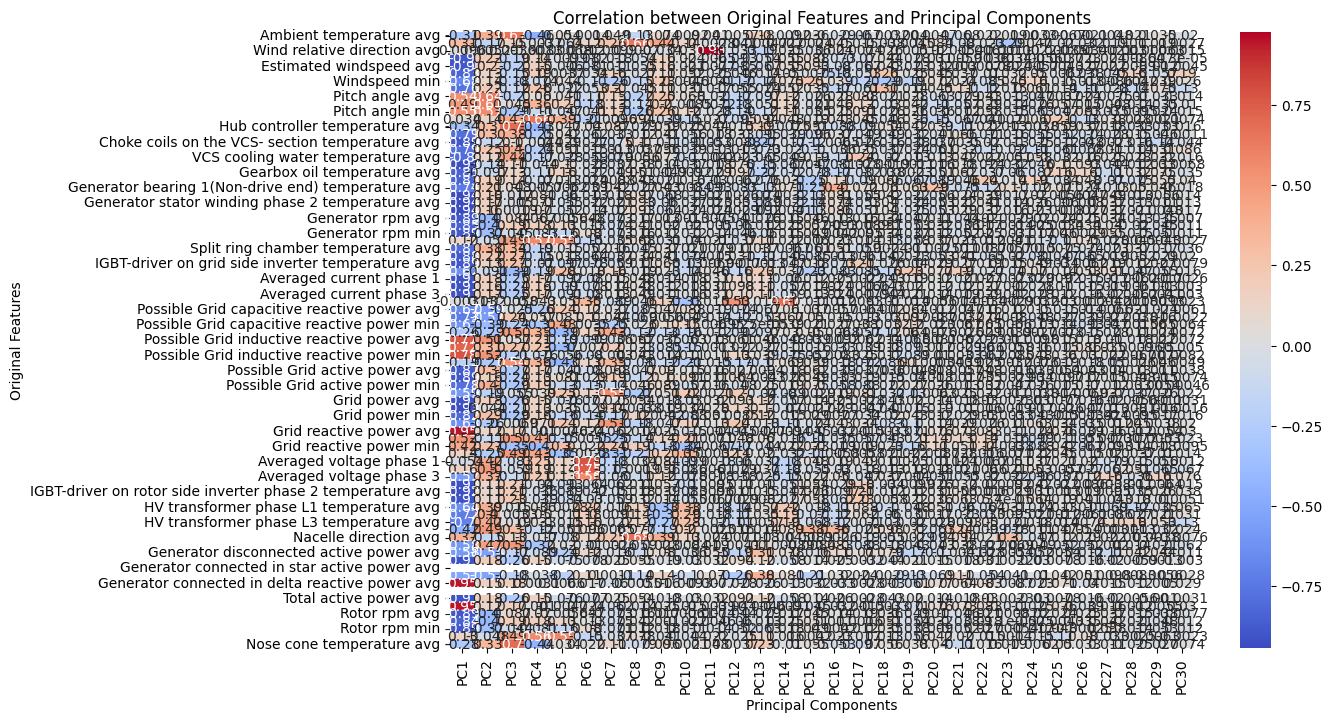

Top Contributing Features for Each Principal Component:
PC1: ['Total reactive power avg' 'Grid reactive power avg'
 'Generator connected in delta reactive power avg'
 'Generator stator winding phase 3 temperature avg'
 'Generator stator winding phase 2 temperature avg']
PC2: ['Pitch angle avg' 'Pitch angle max'
 'Possible Grid capacitive reactive power avg' 'Pitch angle min'
 'Possible Grid capacitive reactive power max']
PC3: ['Nose cone temperature avg' 'Hub controller temperature avg'
 'Ambient temperature avg' 'Possible Grid inductive reactive power std'
 'Grid reactive power max']
PC4: ['Pitch angle std' 'Generator rpm std' 'Rotor rpm std'
 'Ambient temperature avg' 'Nose cone temperature avg']
PC5: ['Generator rpm std' 'Rotor rpm std'
 'Possible Grid capacitive reactive power min'
 'Possible Grid inductive reactive power std'
 'Possible Grid capacitive reactive power std']
PC6: ['Averaged voltage phase 1' 'Averaged voltage phase 2'
 'Averaged voltage phase 3' 'Grid frequency'
 'H

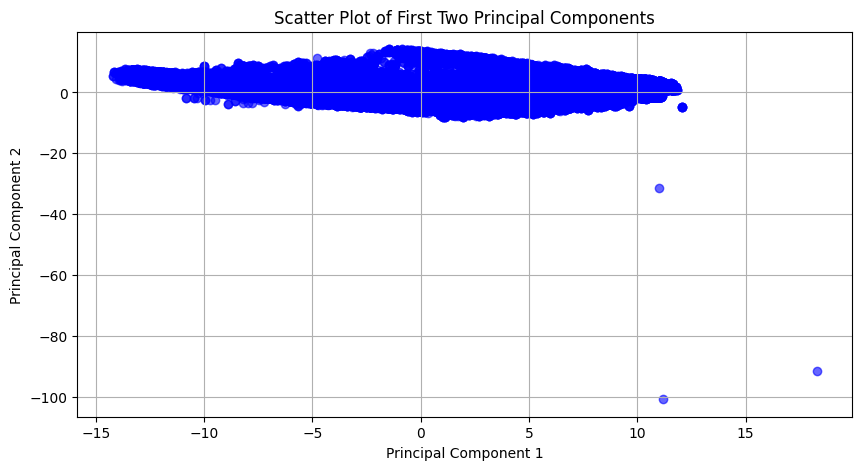

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting features and target variable
X = data.drop('status_type_id', axis=1)
y = data['status_type_id']

# Ensure all columns are numeric or convertible to numeric for model fitting
X = X.select_dtypes(include=['int64', 'float64'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = min(len(X.columns), 30)  # You can adjust this or set based on explained variance
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# 1. Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("Explained Variance Ratio per Component:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Components")
plt.grid()
plt.show()

# 2. Reconstruction Error
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)
print(f"Reconstruction Error (MSE): {reconstruction_error}")

# 3. Correlation Analysis
# Convert X_pca to a DataFrame to calculate correlations
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
correlations = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), X_pca_df], axis=1).corr()

# Display heatmap of correlations between original features and principal components
plt.figure(figsize=(12, 8))
sns.heatmap(correlations.iloc[:len(X.columns), len(X.columns):], annot=True, cmap='coolwarm')
plt.title("Correlation between Original Features and Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.show()

# 4. Principal Component Loadings
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=[f"PC{i+1}" for i in range(n_components)])
print("Top Contributing Features for Each Principal Component:")
for i in range(n_components):
    top_features = loadings.iloc[i].abs().nlargest(5).index  # Get top 5 contributing features for each component
    print(f"PC{i+1}: {top_features.values}")

# 5. Visual Inspection of Data Distribution in PCA Space
# Scatter plot of the first two principal components
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, color='b')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Scatter Plot of First Two Principal Components")
plt.grid()
plt.show()

Explained Variance Ratio per Component: [0.52214243 0.09834276 0.07901652 0.04963011 0.03186671 0.02770703
 0.02322178 0.01980814 0.01607138 0.01448679 0.01273674 0.01209762
 0.01171067 0.01078652 0.00854521 0.00732392 0.00568569 0.00512879
 0.00416133 0.00358385 0.00339718 0.00302885 0.0027007  0.00245463
 0.00220913 0.00205461 0.00172324 0.00161533 0.00158116 0.00144414]
Cumulative Explained Variance: [0.52214243 0.62048519 0.6995017  0.74913182 0.78099852 0.80870555
 0.83192733 0.85173547 0.86780685 0.88229364 0.89503038 0.907128
 0.91883866 0.92962518 0.93817039 0.94549431 0.95118    0.95630879
 0.96047012 0.96405397 0.96745115 0.97048    0.9731807  0.97563533
 0.97784445 0.97989907 0.9816223  0.98323763 0.9848188  0.98626294]
Reconstruction Error (MSE): 0.013397874537115401


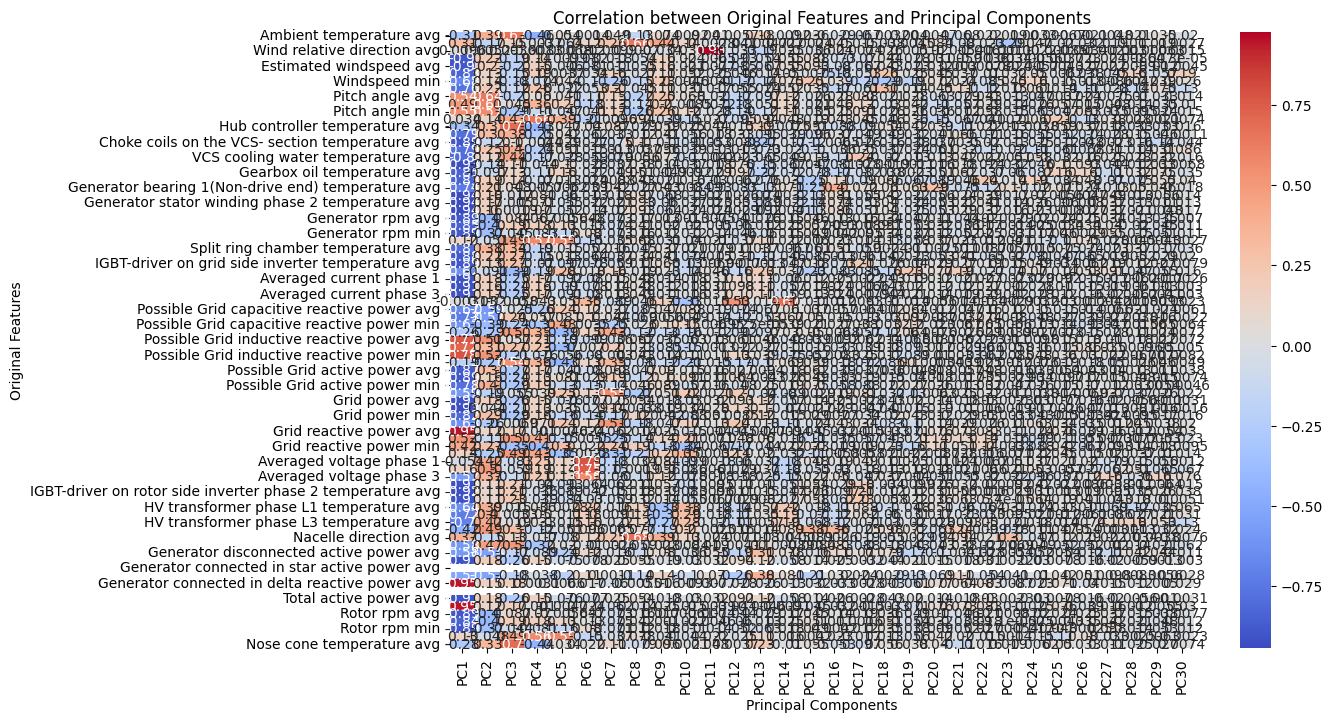

Top Contributing Features for Each Principal Component:
PC1: ['Total reactive power avg' 'Grid reactive power avg'
 'Generator connected in delta reactive power avg'
 'Generator stator winding phase 3 temperature avg'
 'Generator stator winding phase 2 temperature avg']
PC2: ['Pitch angle avg' 'Pitch angle max'
 'Possible Grid capacitive reactive power avg' 'Pitch angle min'
 'Possible Grid capacitive reactive power max']
PC3: ['Nose cone temperature avg' 'Hub controller temperature avg'
 'Ambient temperature avg' 'Possible Grid inductive reactive power std'
 'Grid reactive power max']
PC4: ['Pitch angle std' 'Generator rpm std' 'Rotor rpm std'
 'Ambient temperature avg' 'Nose cone temperature avg']
PC5: ['Generator rpm std' 'Rotor rpm std'
 'Possible Grid capacitive reactive power min'
 'Possible Grid inductive reactive power std'
 'Possible Grid capacitive reactive power std']
PC6: ['Averaged voltage phase 1' 'Averaged voltage phase 2'
 'Averaged voltage phase 3' 'Grid frequency'
 'H

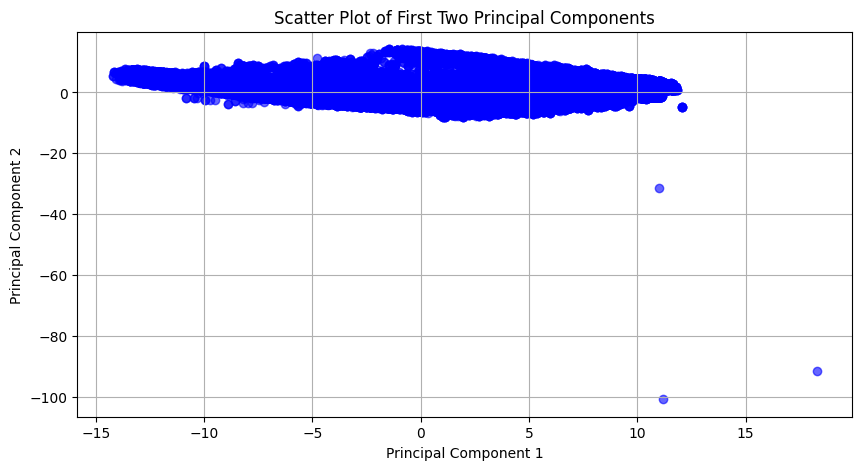

Accuracy of Decision Tree Classifier: 0.9655895648976796
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    180013
           1       0.93      0.93      0.93     59333

    accuracy                           0.97    239346
   macro avg       0.95      0.95      0.95    239346
weighted avg       0.97      0.97      0.97    239346

Confusion Matrix for Decision Tree:
[[175880   4133]
 [  4103  55230]]
Accuracy of Logistic Regression: 0.8971906779306945
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    180013
           1       0.81      0.77      0.79     59333

    accuracy                           0.90    239346
   macro avg       0.87      0.85      0.86    239346
weighted avg       0.90      0.90      0.90    239346

Confusion Matrix for Logistic Regression:
[[169349  10664]
 [ 13943  45390]]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
# Splitting features and target variable
X = data.drop('status_type_id', axis=1)
y = data['status_type_id']

# Ensure all columns are numeric or convertible to numeric for model fitting
X = X.select_dtypes(include=['int64', 'float64'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = min(len(X.columns), 30)  # You can adjust this or set based on explained variance
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# 1. Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("Explained Variance Ratio per Component:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# 2. Reconstruction Error
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)
print(f"Reconstruction Error (MSE): {reconstruction_error}")

# 3. Correlation Analysis
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
correlations = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), X_pca_df], axis=1).corr()

# Display heatmap of correlations between original features and principal components
plt.figure(figsize=(12, 8))
sns.heatmap(correlations.iloc[:len(X.columns), len(X.columns):], annot=True, cmap='coolwarm')
plt.title("Correlation between Original Features and Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.show()

# 4. Principal Component Loadings
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=[f"PC{i+1}" for i in range(n_components)])
print("Top Contributing Features for Each Principal Component:")
for i in range(n_components):
    top_features = loadings.iloc[i].abs().nlargest(5).index  # Get top 5 contributing features for each component
    print(f"PC{i+1}: {top_features.values}")

# 5. Visual Inspection of Data Distribution in PCA Space
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, color='b')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Scatter Plot of First Two Principal Components")
plt.grid()
plt.show()

# 6. Splitting Data for Modeling
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 7. Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of Decision Tree Classifier: {accuracy_dt}")
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))

# 8. Logistic Regression
logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)
logistic_regressor.fit(X_train, y_train)

# Make predictions
y_pred_lr = logistic_regressor.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy of Logistic Regression: {accuracy_lr}")
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test, y_pred_lr))

FEATURE SELECTION USING RANDOM FOREST, LASSO REGRESSION, XGBOOST CLASSIFIER, PRINCIPAL COMPONENT ANALYSIS(PCA), SELECTKBEST, VARIANCE THRESHOLD, CORRELATION WITH TARGET VARIABLE :

In [ ]:
# Splitting features and target variable
X = data.drop('status_type_id', axis=1)
y = data['status_type_id']

# Ensure all columns are numeric or convertible to numeric for model fitting
X = X.select_dtypes(include=['int64', 'float64'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Remove constant columns
constant_filter = VarianceThreshold(threshold=0)
X_filtered = constant_filter.fit_transform(X_scaled)

# Get the mask of the retained features
mask = constant_filter.get_support()

# 1. Feature Importance via Random Forest (reduced n_estimators for speed)
rf = RandomForestClassifier(n_estimators=50, max_depth=5, max_features='sqrt', n_jobs=-1, random_state=42)
rf.fit(X_filtered, y)
importances_rf = rf.feature_importances_
feature_importances_rf = pd.Series(importances_rf, index=X.columns[mask])

# 2. Lasso Regression (using entire dataset)
lasso = Lasso(alpha=0.01)  # Adjusted alpha
lasso.fit(X_filtered, y)
top_lasso_features = X.columns[mask][lasso.coef_ != 0].tolist()

# 3. XGBoost Classifier (faster than traditional Gradient Boosting)
xgb = XGBClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
xgb.fit(X_filtered, y)
importances_xgb = xgb.feature_importances_
feature_importances_xgb = pd.Series(importances_xgb, index=X.columns[mask])

# 4. Principal Component Analysis (PCA)
pca = PCA(n_components=min(len(X.columns[mask]), 20))  # Limit components for speed
pca.fit(X_filtered)

# Get indices of top features for each component
top_pca_features = pca.components_.argsort(axis=1)[:, -10:]

# Create a flat list of original features for top PCA components
top_pca_original_features = []
for component in top_pca_features:
    top_pca_original_features.extend(X.columns[mask][component])  # Use mask to select relevant original features

top_pca_original_features = list(set(top_pca_original_features))  # Unique original feature names

# 5. SelectKBest
selector_kbest = SelectKBest(score_func=f_classif)
selector_kbest.fit(X_filtered, y)
top_kbest_features = X.columns[mask].tolist()

# 6. Variance Threshold
selector_variance = VarianceThreshold(threshold=0.05)  # Adjust threshold if needed
selector_variance.fit(X_filtered)
top_variance_features = X.columns[mask].tolist()

# 7. Correlation with target
numeric_data = data_avg.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_data.corr()
top_corr_features = correlation_matrix['status_type_id'].abs().nlargest(len(correlation_matrix.columns)).index.tolist()
top_corr_features.remove('status_type_id')  # Remove the target itself

# Store selected features in a dictionary, limiting to top n features
n_top_features = 35  # Set the limit for top features
selected_features = {
    'random_forest': feature_importances_rf.nlargest(n_top_features).index.tolist(),
    'lasso': top_lasso_features[:n_top_features],  # Adjusted to take top n
    'xgboost': feature_importances_xgb.nlargest(n_top_features).index.tolist(),
    'pca': top_pca_original_features[:n_top_features],  # Limit to top n
    'select_k_best': top_kbest_features[:n_top_features],  # Limit to top n
    'variance_threshold': top_variance_features[:n_top_features],  # Limit to top n
    'correlation': top_corr_features[:n_top_features]  # Limit to top n
}

# Find common features across all methods
all_selected_features = sum(selected_features.values(), [])
feature_counter = Counter(all_selected_features)

# Choose features selected by at least a majority of the methods (set to 4)
majority_threshold = 4  # Adjust as needed
common_features = [feature for feature, count in feature_counter.items() if count >= majority_threshold]

# Unique features from common features
unique_selected_features = set(common_features)  # Keep only unique common features

# Print the results
print("Selected features from each method:")
for method, features in selected_features.items():
    print(f"{method}: {features}")

print("\nCommon features selected by multiple methods:", common_features)
print("\nUnique selected features (without redundancy):", unique_selected_features)

Selected features from each method:
random_forest: ['Total active power avg', 'Estimated windspeed avg', 'Windspeed avg', 'Generator rpm avg', 'Grid power avg', 'Possible Grid inductive reactive power avg', 'Averaged current phase 1', 'Possible Grid capacitive reactive power avg', 'Rotor rpm avg', 'Generator connected in delta active power avg', 'Generator connected in delta reactive power avg', 'Possible Grid active power max', 'Pitch angle max', 'Averaged current phase 3', 'Total reactive power avg', 'Generator rpm min', 'Pitch angle avg', 'Possible Grid active power std', 'Generator disconnected active power avg', 'Averaged current phase 2', 'Possible Grid inductive reactive power max', 'Possible Grid active power avg', 'Grid reactive power avg', 'Rotor rpm max', 'Grid power max', 'Grid power min', 'Rotor rpm std', 'Generator rpm max', 'Windspeed max', 'Windspeed min', 'Windspeed std', 'Rotor rpm min', 'Grid power std', 'Pitch angle min', 'Possible Grid active power min']
lasso: ['P

In [ ]:
# Create a list of unique selected features
unique_selected_features = ['status_type_id','Averaged current phase 1', 'VCP-board temperature avg', 'Possible Grid inductive reactive power avg', 'Generator stator winding phase 1 temperature avg', 'Busbar section temperature avg', 'Generator bearing 2(Drive end)  temperature avg', 'Wind relative direction avg', 'VCS cooling water temperature avg', 'Possible Grid active power avg', 'Windspeed avg', 'Averaged current phase 2', 'Split ring chamber temperature avg', 'Estimated windspeed avg', 'IGBT-driver on grid side inverter temperature avg', 'Averaged current phase 3', 'Generator stator winding phase 3 temperature avg', 'Generator bearing 1(Non-drive end) temperature avg', 'Gearbox bearing on high speed shaft  temperature avg', 'Actual Phase displacement avg', 'Gearbox oil temperature avg', 'Pitch angle avg', 'Possible Grid capacitive reactive power avg', 'Generator stator winding phase 2 temperature avg', 'Ambient temperature avg', 'Choke coils on the VCS- section temperature avg', 'Generator rpm avg']

# Create a new dataset with only the unique selected features
unique_data_avg = data[unique_selected_features]


In [ ]:
# Create a list of unique selected features
unique_features = ['status_type_id', 'Generator rpm avg', 'Generator rpm max', 'Ambient temperature avg', 'Split ring chamber temperature avg', 'Pitch angle avg', 'IGBT-driver on grid side inverter temperature avg', 'Pitch angle min', 'Generator stator winding phase 2 temperature avg', 'Windspeed std', 'Generator bearing 1(Non-drive end) temperature avg', 'Busbar section temperature avg', 'Actual Phase displacement avg', 'Hub controller temperature avg', 'VCP-board temperature avg', 'Total active power avg', 'Averaged current phase 2', 'Windspeed avg', 'Averaged current phase 3', 'Top nacelle controller temperature avg', 'Estimated windspeed avg', 'Gearbox oil temperature avg', 'Generator stator winding phase 1 temperature avg', 'Generator bearing 2(Drive end)  temperature avg', 'Choke coils on the VCS- section temperature avg', 'Pitch angle max', 'Possible Grid capacitive reactive power avg', 'Averaged current phase 1', 'Windspeed min', 'VCS cooling water temperature avg']

# Create a new dataset with only the unique selected features
unique_data = data[unique_features]

LEARNING CURVES COMPARISON

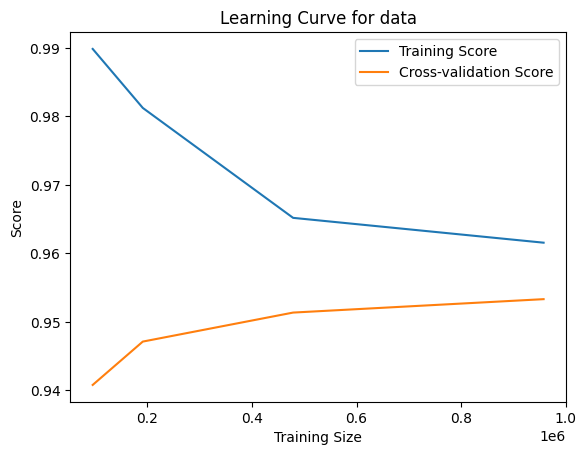

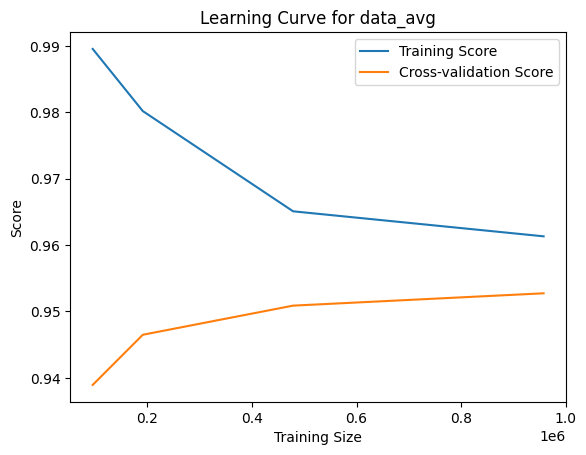

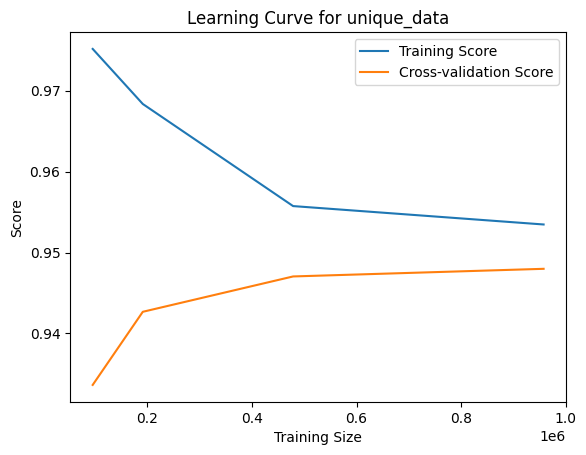

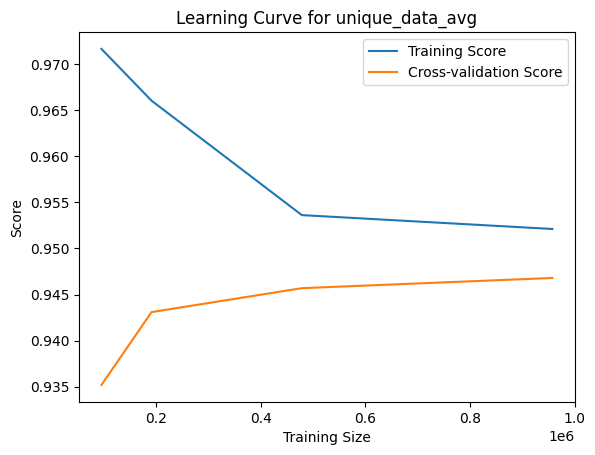

In [ ]:
# Learning Curves Comparison
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']
for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Generate learning curves
    train_sizes, train_scores, test_scores = learning_curve(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                                                            X_scaled, y, n_jobs=-1, train_sizes=[0.1, 0.2, 0.5, 1.0], cv=5)

    # Calculate mean and std deviation
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    # Plot the learning curve
    plt.figure()
    plt.plot(train_sizes, train_mean, label='Training Score')
    plt.plot(train_sizes, test_mean, label='Cross-validation Score')
    plt.title(f'Learning Curve for {dataset_names[i]}')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

FEATURE IMPORTANCE COMPARISON

Top 20 features for data:

Total active power avg: 0.3711
Grid power avg: 0.3539
Windspeed avg: 0.1232
Possible Grid inductive reactive power avg: 0.0094
Hydraulic group oil temperature avg: 0.0059
IGBT-driver on rotor side inverter phase 2 temperature avg: 0.0041
Possible Grid capacitive reactive power min: 0.0038
Gearbox oil temperature avg: 0.0038
Nacelle temperature avg: 0.0034
IGBT-driver on rotor side inverter phase 1 temperature avg: 0.0031
Ambient temperature avg: 0.0031
Windspeed std: 0.0030
Nose cone temperature avg: 0.0029
Split ring chamber temperature avg: 0.0029
Actual Phase displacement avg: 0.0028
HV transformer phase L3 temperature avg: 0.0028
Estimated windspeed avg: 0.0027
Generator bearing 2(Drive end)  temperature avg: 0.0027
Nacelle direction avg: 0.0026
Generator bearing 1(Non-drive end) temperature avg: 0.0025


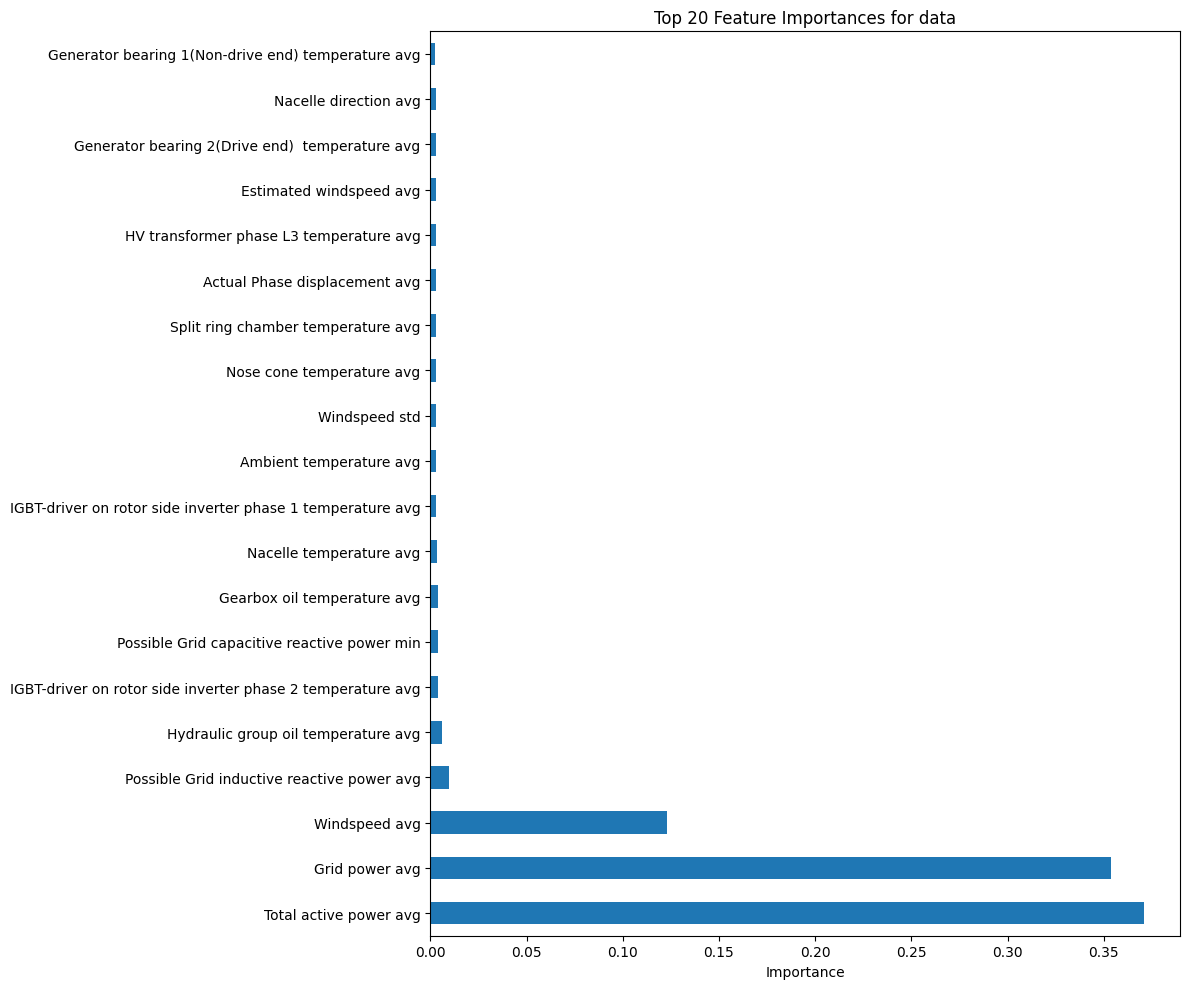

Top 20 features for data_avg:

Total active power avg: 0.4251
Grid power avg: 0.3195
Windspeed avg: 0.1251
Possible Grid inductive reactive power avg: 0.0090
Hydraulic group oil temperature avg: 0.0068
Nacelle temperature avg: 0.0047
Gearbox oil temperature avg: 0.0043
Ambient temperature avg: 0.0040
IGBT-driver on rotor side inverter phase 2 temperature avg: 0.0038
IGBT-driver on rotor side inverter phase 1 temperature avg: 0.0037
HV transformer phase L3 temperature avg: 0.0036
Actual Phase displacement avg: 0.0036
Split ring chamber temperature avg: 0.0033
Nacelle direction avg: 0.0032
VCP-board temperature avg: 0.0032
IGBT-driver on rotor side inverter phase 3 temperature avg: 0.0032
Generator bearing 1(Non-drive end) temperature avg: 0.0032
Busbar section temperature avg: 0.0031
Generator bearing 2(Drive end)  temperature avg: 0.0031
Nose cone temperature avg: 0.0030


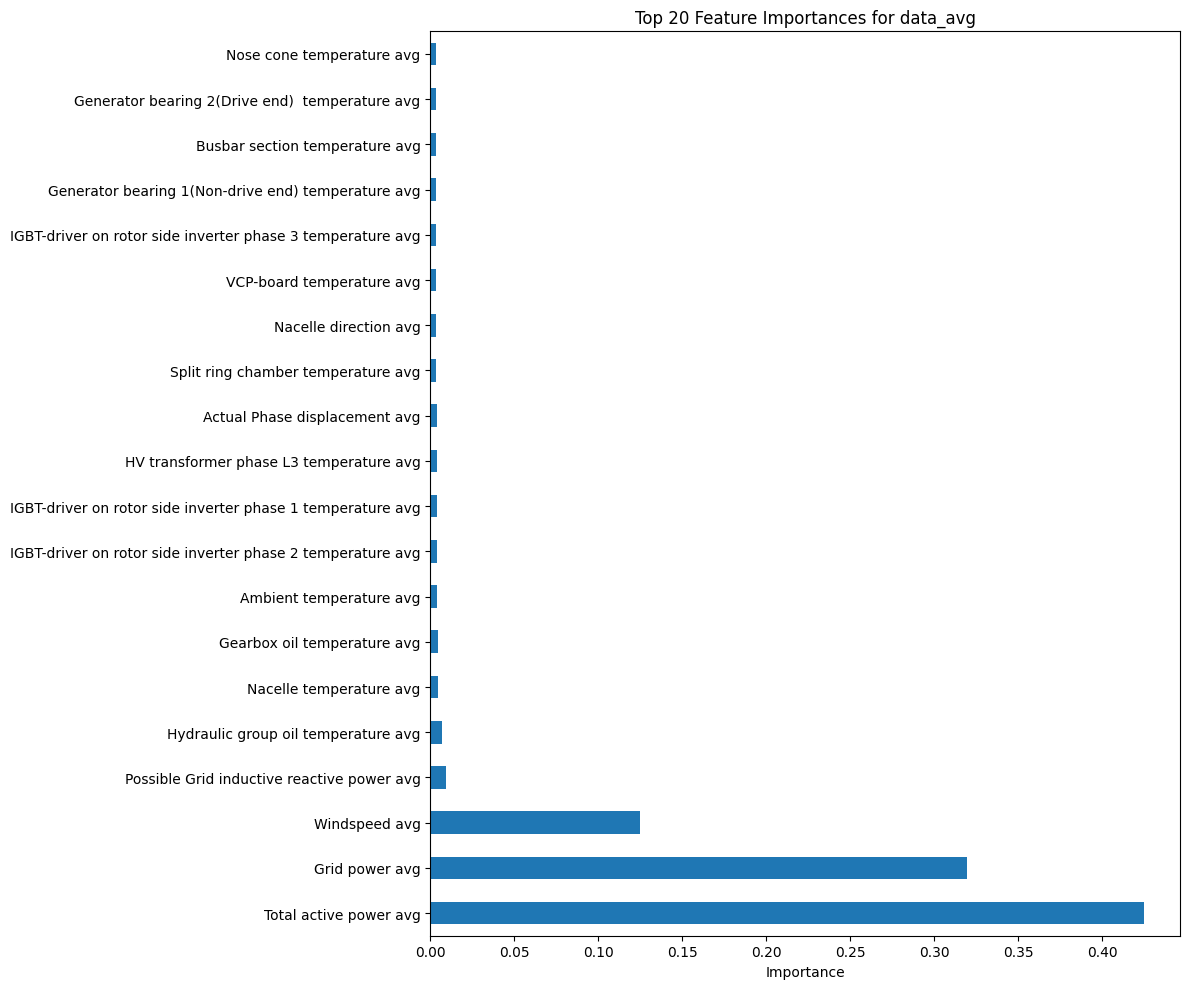

Top 20 features for unique_data:

Total active power avg: 0.5144
Windspeed avg: 0.3034
Possible Grid capacitive reactive power avg: 0.0249
Ambient temperature avg: 0.0129
Generator bearing 1(Non-drive end) temperature avg: 0.0090
Split ring chamber temperature avg: 0.0085
Gearbox oil temperature avg: 0.0085
Estimated windspeed avg: 0.0082
VCP-board temperature avg: 0.0078
Generator bearing 2(Drive end)  temperature avg: 0.0068
Averaged current phase 2: 0.0066
Generator stator winding phase 1 temperature avg: 0.0064
Choke coils on the VCS- section temperature avg: 0.0064
Busbar section temperature avg: 0.0062
Top nacelle controller temperature avg: 0.0061
Actual Phase displacement avg: 0.0060
Windspeed min: 0.0057
Generator stator winding phase 2 temperature avg: 0.0057
Windspeed std: 0.0053
Hub controller temperature avg: 0.0053


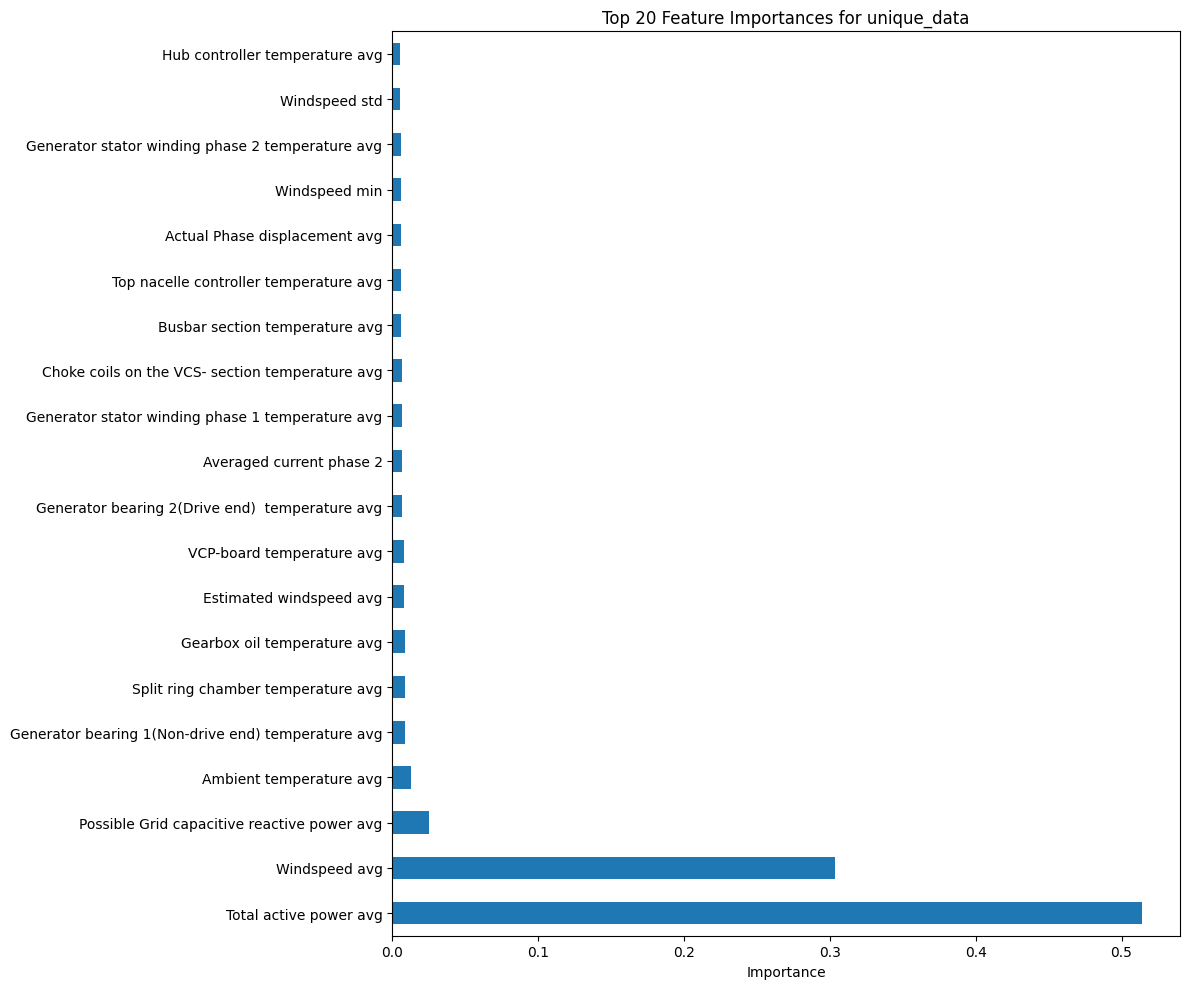

Top 20 features for unique_data_avg:

Possible Grid inductive reactive power avg: 0.4714
Possible Grid capacitive reactive power avg: 0.2102
Windspeed avg: 0.1924
Averaged current phase 2: 0.0218
Ambient temperature avg: 0.0084
Generator bearing 1(Non-drive end) temperature avg: 0.0073
Split ring chamber temperature avg: 0.0065
VCP-board temperature avg: 0.0062
Gearbox oil temperature avg: 0.0061
Estimated windspeed avg: 0.0059
Generator bearing 2(Drive end)  temperature avg: 0.0057
Actual Phase displacement avg: 0.0057
Generator stator winding phase 2 temperature avg: 0.0050
Gearbox bearing on high speed shaft  temperature avg: 0.0046
Choke coils on the VCS- section temperature avg: 0.0046
Pitch angle avg: 0.0044
Generator stator winding phase 1 temperature avg: 0.0042
Busbar section temperature avg: 0.0040
Generator stator winding phase 3 temperature avg: 0.0040
Generator rpm avg: 0.0037


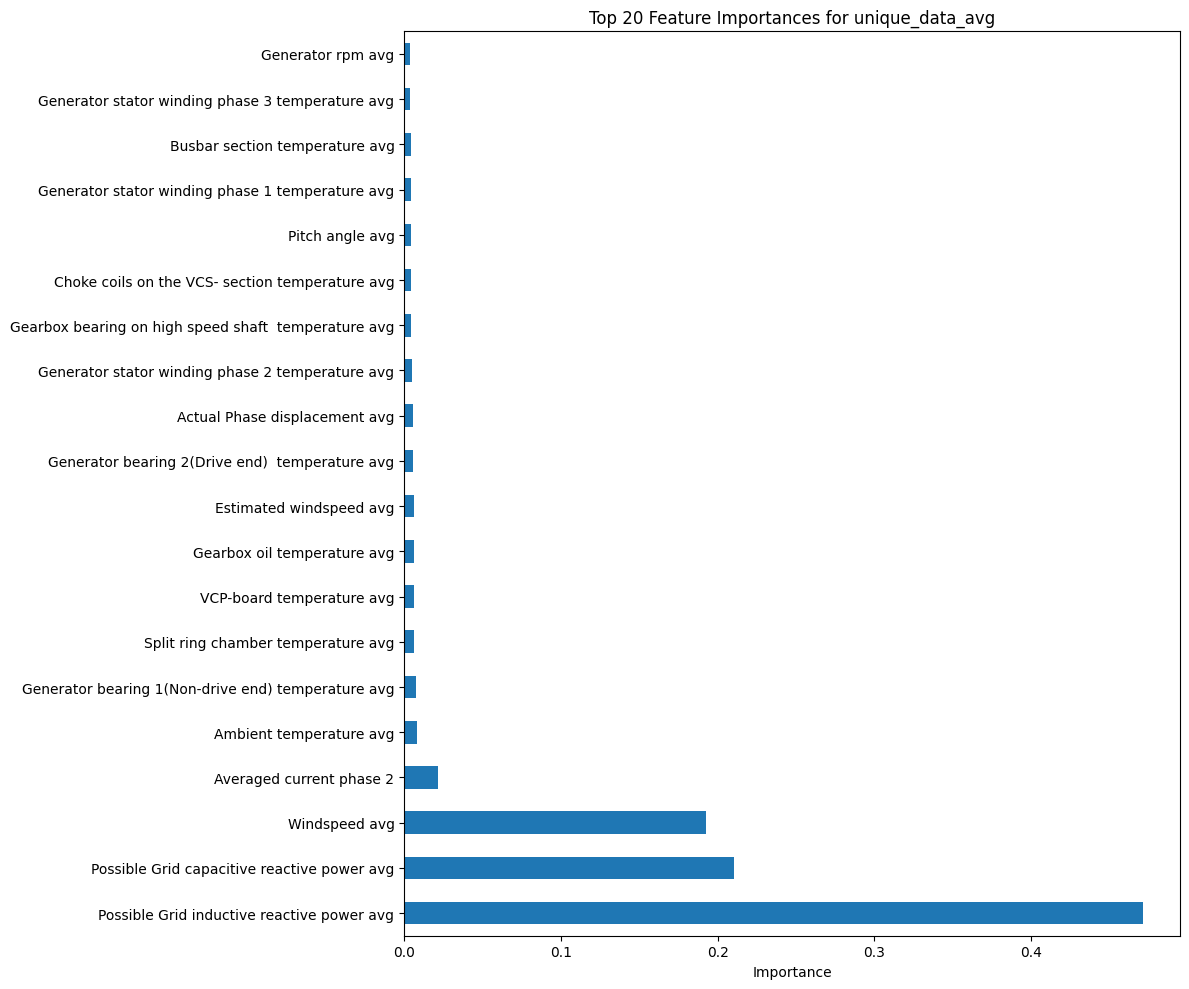

In [ ]:
# Feature Importance Comparison
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']

# Assuming datasets and dataset_names are already defined
feature_importance_results = {}

for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)

    # Only keep numeric columns for scaling and model input
    X_numeric = X.select_dtypes(include=['float64', 'int64'])
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_numeric)

    # Remove constant columns
    constant_filter = VarianceThreshold(threshold=0)
    X_filtered = constant_filter.fit_transform(X_scaled)

    # Get the mask of retained features
    mask = constant_filter.get_support()

    # Create the XGBoost model
    xgb_model = XGBClassifier(eval_metric='logloss')

    # Fit the model
    xgb_model.fit(X_filtered, y)

    # Get the feature importances corresponding to the retained features
    feature_importances = pd.Series(xgb_model.feature_importances_,
                                    index=X_numeric.columns[mask][:len(xgb_model.feature_importances_)])

    # Store results for later analysis
    feature_importance_results[dataset_names[i]] = feature_importances[feature_importances.index.isin(X_numeric.columns[mask])]

    # Sort by importance and select top 20 features
    top_features = feature_importance_results[dataset_names[i]].nlargest(20)

    # Print top 20 feature names and their importances
    print(f"Top 20 features for {dataset_names[i]}:\n")
    for feature, importance in zip(top_features.index, top_features):
        print(f"{feature}: {importance:.4f}")

    # Plot top 20 feature importances
    plt.figure(figsize=(12, 10))  # Set a larger figure size for clarity
    top_features.plot(kind='barh')
    plt.title(f'Top 20 Feature Importances for {dataset_names[i]}')
    plt.xlabel('Importance')
    plt.xticks(fontsize=10)  # Adjust fontsize for better readability
    plt.yticks(fontsize=10)  # Adjust y-axis fontsize for clear labels
    plt.tight_layout()  # Ensure everything fits without overlap
    plt.show()

PERMUTATION IMPORTANCE COMPARISON

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top 20 features for data:

HV transformer phase L1 temperature avg: 0.0038722281689975713
Generator bearing 1(Non-drive end) temperature avg: 0.004010939838409167
Nose cone temperature avg: 0.004041021887197238
Split ring chamber temperature avg: 0.0045858412152478545
VCP-board temperature avg: 0.004828168830485091
Ambient temperature avg: 0.004992784486353208
IGBT-driver on rotor side inverter phase 2 temperature avg: 0.00603813568173861
IGBT-driver on rotor side inverter phase 3 temperature avg: 0.0064668048769686015
Generator rpm avg: 0.006669023093821669
Generator bearing 2(Drive end)  temperature avg: 0.006676543606018659
Nacelle direction avg: 0.006789351288973955
Generator stator winding phase 3 temperature avg: 0.007847236671354452
Hydraulic group oil temperature avg: 0.009417352495598386
Choke coils on the VCS- section temperature avg: 0.009566927127072411
HV transformer phase L2 temperature avg: 0.011483822124845444
Generator stator winding phase 2 temperature avg: 0.01285506

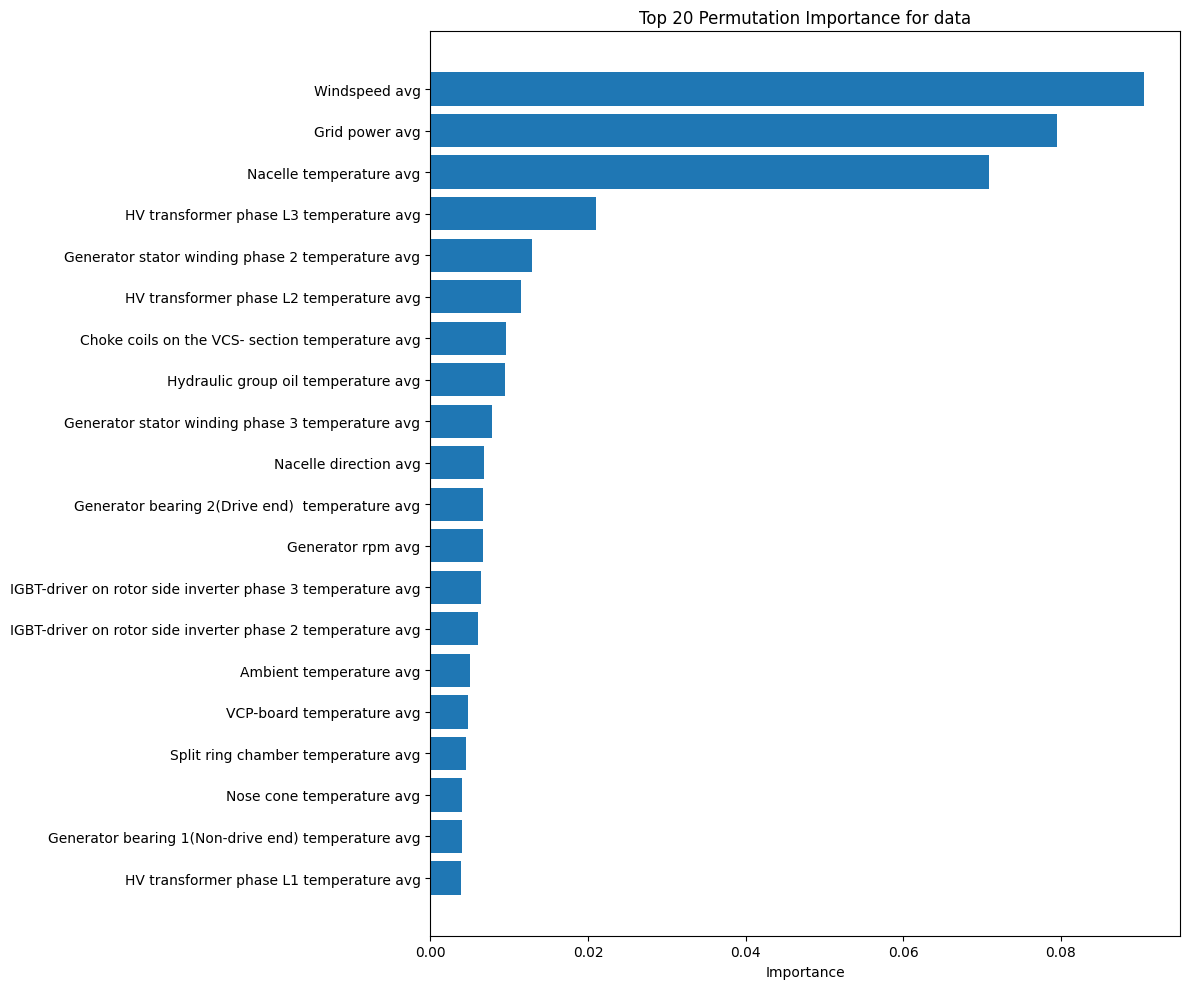

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:14:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top 20 features for data_avg:

IGBT-driver on rotor side inverter phase 3 temperature avg: 0.004227363467190104
Split ring chamber temperature avg: 0.004258281128444508
Nose cone temperature avg: 0.004887497315595013
Generator bearing 2(Drive end)  temperature avg: 0.005729794681660905
Ambient temperature avg: 0.006135902340299926
Nacelle direction avg: 0.006758433627719662
Total active power avg: 0.008061153462736281
Hub controller temperature avg: 0.008246659430262704
IGBT-driver on rotor side inverter phase 2 temperature avg: 0.008373672525145759
Generator stator winding phase 3 temperature avg: 0.008674493013026363
Generator rpm avg: 0.008723794148540187
VCP-board temperature avg: 0.009093134858660368
Choke coils on the VCS- section temperature avg: 0.009299531137845207
Hydraulic group oil temperature avg: 0.012571789556014124
HV transformer phase L2 temperature avg: 0.016241799508158516
Generator stator winding phase 2 temperature avg: 0.020739901414441264
HV transformer phase L3 

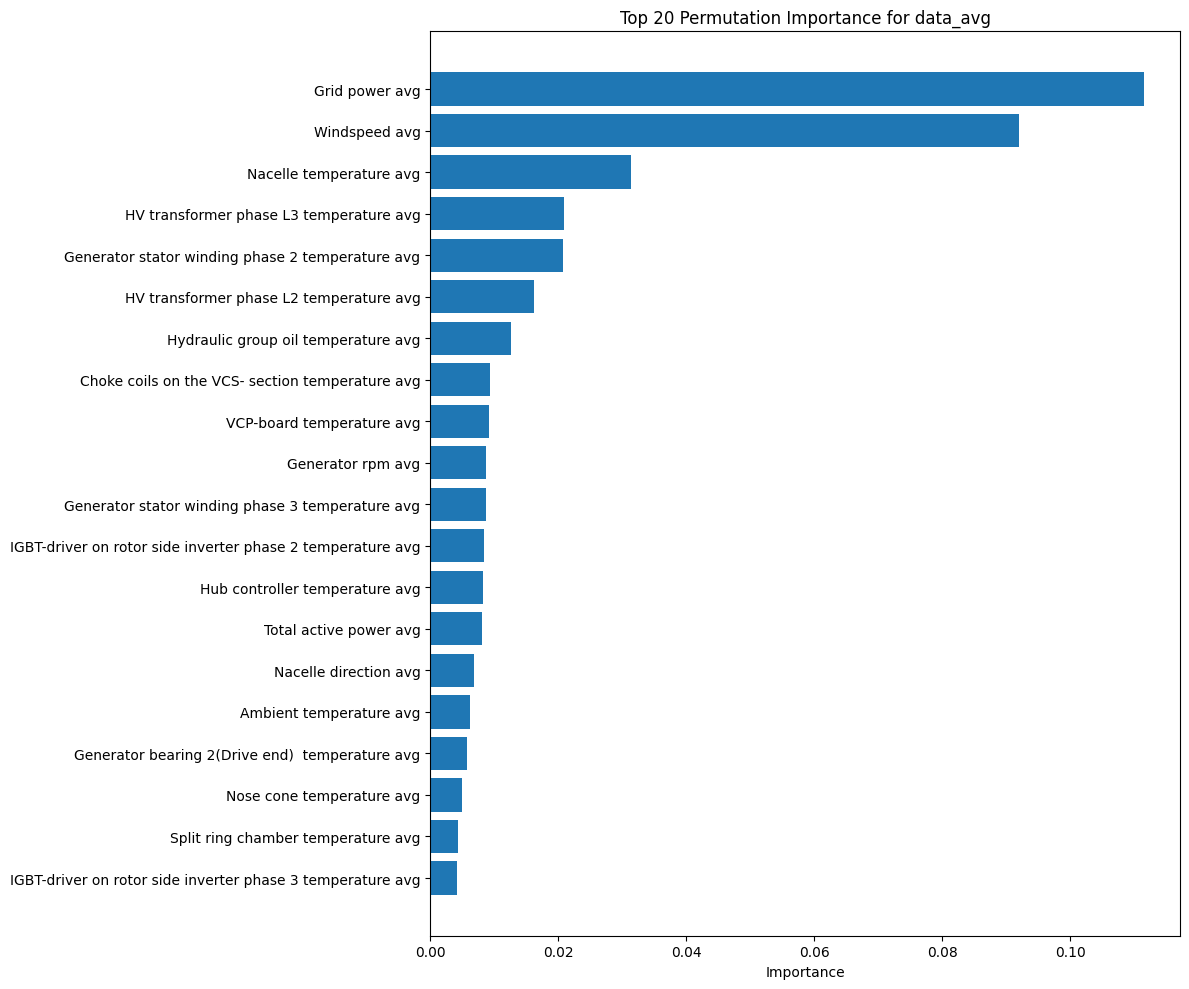

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:19:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top 20 features for unique_data:

VCS cooling water temperature avg: 0.0023564271550653437
Windspeed std: 0.0023706325669931028
Generator rpm max: 0.0031502589980838547
Top nacelle controller temperature avg: 0.0031669712474106104
Averaged current phase 2: 0.004140459770691218
Generator bearing 2(Drive end)  temperature avg: 0.004803936068961345
Hub controller temperature avg: 0.0054857958414910035
Averaged current phase 3: 0.005943711473042623
Split ring chamber temperature avg: 0.0072430888581940245
Generator bearing 1(Non-drive end) temperature avg: 0.007460348099441183
Busbar section temperature avg: 0.009007902387094036
Averaged current phase 1: 0.009663858173167283
VCP-board temperature avg: 0.01176960158833218
Choke coils on the VCS- section temperature avg: 0.019965288658148395
Ambient temperature avg: 0.020464149300550516
Generator stator winding phase 1 temperature avg: 0.025445235212375072
Gearbox oil temperature avg: 0.028461796215845325
Generator stator winding phase 2 tem

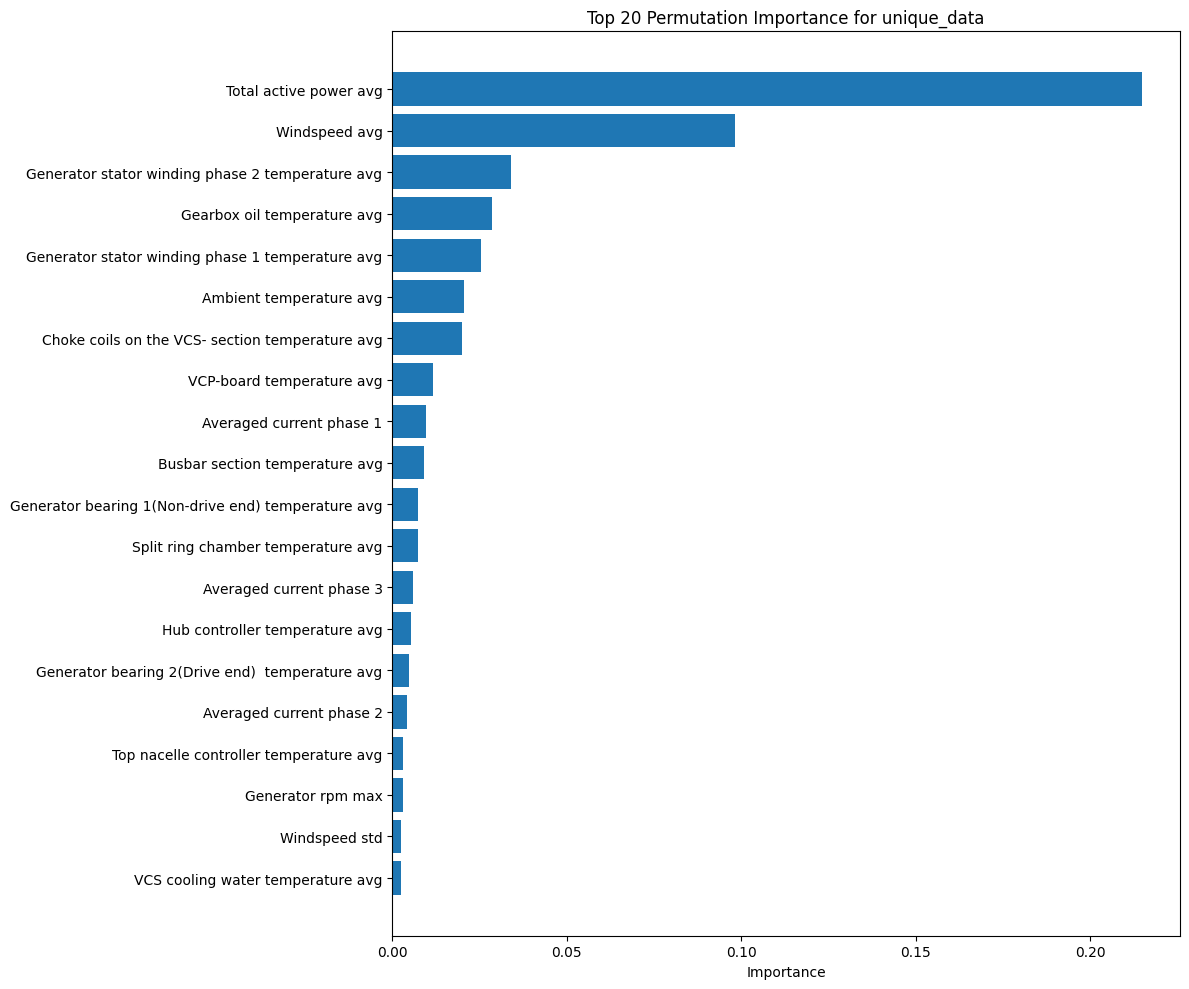

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:21:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top 20 features for unique_data_avg:

VCS cooling water temperature avg: 0.002618809469494665
Pitch angle avg: 0.0026246587567589907
Averaged current phase 3: 0.003285628217630232
Averaged current phase 2: 0.005478275329293902
Busbar section temperature avg: 0.006119190090973059
Gearbox bearing on high speed shaft  temperature avg: 0.006320572695359905
Possible Grid capacitive reactive power avg: 0.006454270689973507
Generator bearing 2(Drive end)  temperature avg: 0.007627470592708185
Generator bearing 1(Non-drive end) temperature avg: 0.009627926837114886
Gearbox oil temperature avg: 0.009682241647426593
VCP-board temperature avg: 0.009723186658277094
Ambient temperature avg: 0.012395475325617245
Generator stator winding phase 1 temperature avg: 0.01468588909584223
Averaged current phase 1: 0.015731240291227633
Split ring chamber temperature avg: 0.020515957273463337
Generator stator winding phase 3 temperature avg: 0.026549079280403953
Choke coils on the VCS- section temperature avg

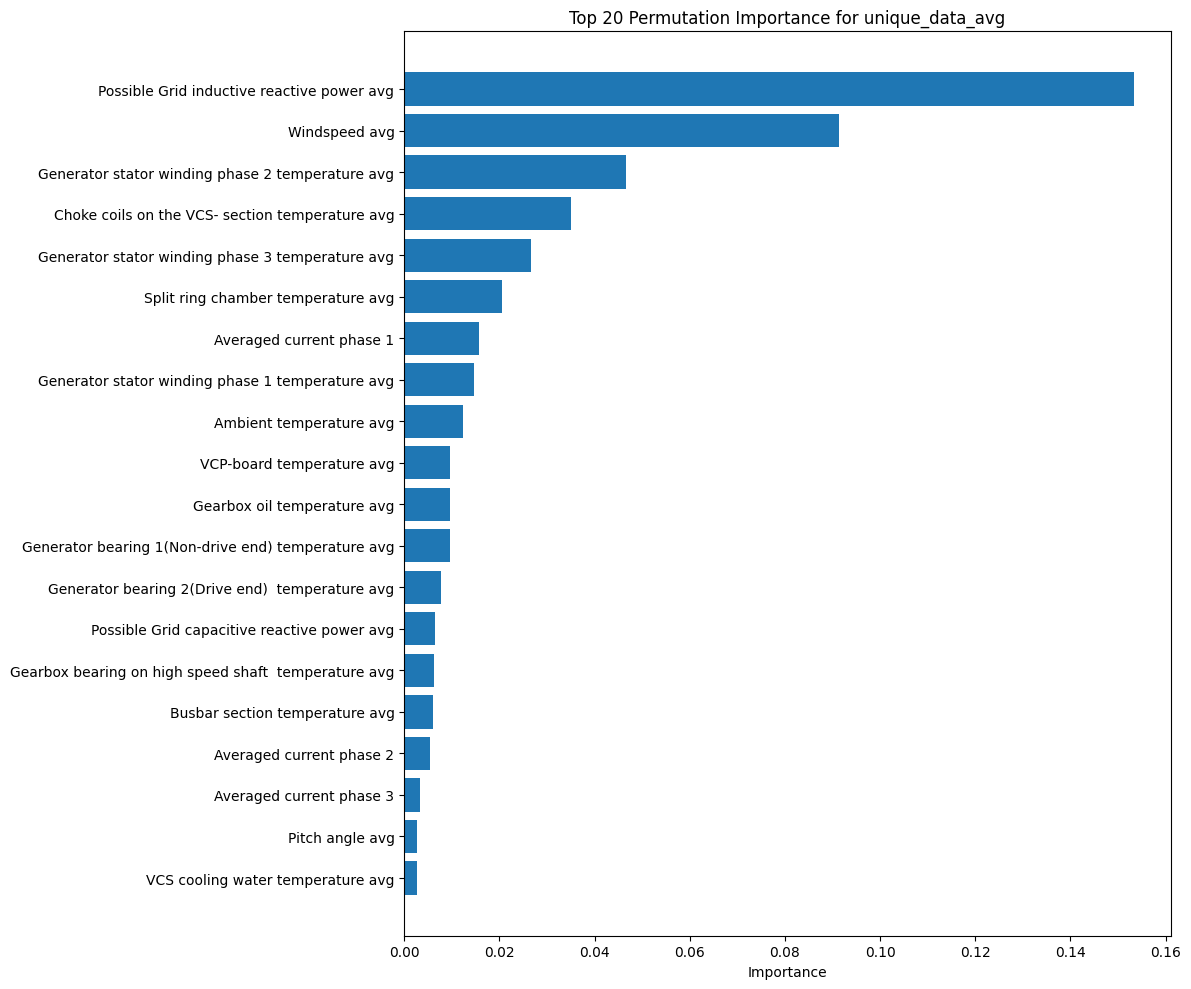

In [ ]:
# Permutation Importance Comparison
# Assuming 'datasets' is a list of your DataFrames
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']
for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Create the XGBoost model
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Fit the model
    xgb_model.fit(X_scaled, y)

    # Calculate permutation importance
    result = permutation_importance(xgb_model, X_scaled, y, n_repeats=1, random_state=42, n_jobs=-1)

    # Sort by importance and select top 20 features
    sorted_idx = result.importances_mean.argsort()[-20:]  # Top 20 features

    # Print top 20 feature names and their importances
    top_20_features = X.columns[sorted_idx]
    top_20_importances = result.importances_mean[sorted_idx]

    print(f"Top 20 features for {dataset_names[i]}:\n")
    for feature, importance in zip(top_20_features, top_20_importances):
        print(f"{feature}: {importance}")

    # Plot permutation importance for top 20 features
    plt.figure(figsize=(12, 10))  # Set a larger figure size for clarity
    plt.barh(top_20_features, top_20_importances)
    plt.title(f'Top 20 Permutation Importance for {dataset_names[i]}')
    plt.xlabel('Importance')
    plt.xticks(fontsize=10)  # Adjust fontsize for better readability
    plt.yticks(fontsize=10)  # Adjust y-axis fontsize for clear labels
    plt.tight_layout()  # Ensure everything fits without overlap
    plt.show()

ACCURACY COMPARISON USING XGBOOST


In [ ]:
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']

for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Create the XGBoost model
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Fit the model to the training data
    xgb_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_names[i]}: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:02:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for data: 0.9607221344831331
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    181235
           1       0.95      0.89      0.92     58111

    accuracy                           0.96    239346
   macro avg       0.96      0.94      0.95    239346
weighted avg       0.96      0.96      0.96    239346

Confusion Matrix:
[[178348   2887]
 [  6514  51597]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for data_avg: 0.960559190460672
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    181235
           1       0.95      0.89      0.92     58111

    accuracy                           0.96    239346
   macro avg       0.96      0.94      0.95    239346
weighted avg       0.96      0.96      0.96    239346

Confusion Matrix:
[[178313   2922]
 [  6518  51593]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for unique_data: 0.9539369782657743
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    181235
           1       0.93      0.87      0.90     58111

    accuracy                           0.95    239346
   macro avg       0.95      0.93      0.94    239346
weighted avg       0.95      0.95      0.95    239346

Confusion Matrix:
[[177714   3521]
 [  7504  50607]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for unique_data_avg: 0.9536528707394316
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    181235
           1       0.93      0.87      0.90     58111

    accuracy                           0.95    239346
   macro avg       0.95      0.93      0.94    239346
weighted avg       0.95      0.95      0.95    239346

Confusion Matrix:
[[177699   3536]
 [  7557  50554]]




ACCURACY COMPARISON USING LOGISTIC REGRESSION MODEL

In [ ]:
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']

for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Define the final Logistic Regression model with specified parameters
    final_model = LogisticRegression(solver='lbfgs', C=50.01770575333992, max_iter=3000)

    # Train the model on the scaled training data
    final_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = final_model.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_names[i]}: {accuracy}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Accuracy for data: 0.9185321668212546
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    181235
           1       0.88      0.76      0.82     58111

    accuracy                           0.92    239346
   macro avg       0.91      0.87      0.88    239346
weighted avg       0.92      0.92      0.92    239346

Confusion Matrix:
[[175396   5839]
 [ 13660  44451]]


Accuracy for data_avg: 0.9073684122567329
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    181235
           1       0.85      0.76      0.80     58111

    accuracy                           0.91    239346
   macro avg       0.88      0.86      0.87    239346
weighted avg       0.91      0.91      0.91    239346

Confusion Matrix:
[[173171   8064]
 [ 14107  44004]]


Accuracy for unique_data: 0.8953021984908877
Classification Report:
              precision    recall  f1-scor

ACCURACY COMPARISON USING SGD CLASSIFIER MODEL

In [ ]:
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']

for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Define the final SGD Classifier model
    final_model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)

    # Train the model on the scaled training data
    final_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = final_model.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_names[i]}: {accuracy}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Accuracy for data: 0.9111161247733407
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    181235
           1       0.81      0.82      0.82     58111

    accuracy                           0.91    239346
   macro avg       0.88      0.88      0.88    239346
weighted avg       0.91      0.91      0.91    239346

Confusion Matrix:
[[170391  10844]
 [ 10430  47681]]


Accuracy for data_avg: 0.8978215637612494
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    181235
           1       0.79      0.78      0.79     58111

    accuracy                           0.90    239346
   macro avg       0.86      0.86      0.86    239346
weighted avg       0.90      0.90      0.90    239346

Confusion Matrix:
[[169408  11827]
 [ 12629  45482]]


Accuracy for unique_data: 0.8834407092660834
Classification Report:
              precision    recall  f1-scor

ACCCURACY COMPARISON USING NAIVE BAYES MODEL

In [ ]:
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']

for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Define the final Naive Bayes model
    final_model = GaussianNB()

    # Train the model on the scaled training data
    final_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = final_model.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_names[i]}: {accuracy}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Accuracy for data: 0.8259966742707211
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88    181235
           1       0.60      0.88      0.71     58111

    accuracy                           0.83    239346
   macro avg       0.77      0.84      0.79    239346
weighted avg       0.87      0.83      0.84    239346

Confusion Matrix:
[[146787  34448]
 [  7199  50912]]


Accuracy for data_avg: 0.7868984649837474
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84    181235
           1       0.54      0.88      0.67     58111

    accuracy                           0.79    239346
   macro avg       0.74      0.82      0.76    239346
weighted avg       0.85      0.79      0.80    239346

Confusion Matrix:
[[137246  43989]
 [  7016  51095]]


Accuracy for unique_data: 0.8048599099212019
Classification Report:
              precision    recall  f1-scor

ACCURACY COMPARISON USING DECISION TREES MODEL

In [ ]:
datasets = [data, data_avg, unique_data, unique_data_avg]
dataset_names = ['data', 'data_avg', 'unique_data', 'unique_data_avg']

for i, dataset in enumerate(datasets):
    # Prepare data
    X = dataset.drop(['status_type_id'], axis=1)
    y = dataset['status_type_id']

    # Scale data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Define the final Decision Tree model
    final_model = DecisionTreeClassifier()

    # Train the model on the scaled training data
    final_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = final_model.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_names[i]}: {accuracy}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Accuracy for data: 0.9835886123018559
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    181235
           1       0.98      0.95      0.97     58111

    accuracy                           0.98    239346
   macro avg       0.98      0.97      0.98    239346
weighted avg       0.98      0.98      0.98    239346

Confusion Matrix:
[[180027   1208]
 [  2720  55391]]


Accuracy for data_avg: 0.9834674487979744
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    181235
           1       0.98      0.95      0.97     58111

    accuracy                           0.98    239346
   macro avg       0.98      0.97      0.98    239346
weighted avg       0.98      0.98      0.98    239346

Confusion Matrix:
[[180033   1202]
 [  2755  55356]]


Accuracy for unique_data: 0.9822892381740242
Classification Report:
              precision    recall  f1-scor

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Assuming 'data' is your DataFrame
# Separate features and target variable
X = data.drop(columns=['event_description'])  # Adjust based on feature columns
y = data['event_description']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the resampled training data
dt_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[75865  7185 10584 23791  2853]
 [11473  4276   333  6146     0]
 [19779   173   264  1318     0]
 [52686  4872  1356  5520     0]
 [10552     0     1     0   319]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.63      0.52    120278
           1       0.26      0.19      0.22     22228
           2       0.02      0.01      0.02     21534
           3       0.15      0.09      0.11     64434
           4       0.10      0.03      0.05     10872

    accuracy                           0.36    239346
   macro avg       0.20      0.19      0.18    239346
weighted avg       0.29      0.36      0.32    239346

Accuracy Score: 0.3603319044395979


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Assuming 'data' is your DataFrame
# Features and target variable
X = data.drop(columns=['event_description'])  # Adjust as needed
y = data['event_description']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model on the resampled training data
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[83595  5906  7399 22381   997]
 [ 5986  9453   180  6609     0]
 [15403   699  5353    79     0]
 [27796  3302  4241 29095     0]
 [10162     0     0     5   705]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.70      0.64    120278
           1       0.49      0.43      0.45     22228
           2       0.31      0.25      0.28     21534
           3       0.50      0.45      0.47     64434
           4       0.41      0.06      0.11     10872

    accuracy                           0.54    239346
   macro avg       0.46      0.38      0.39    239346
weighted avg       0.52      0.54      0.52    239346

Accuracy Score: 0.5356304262448506


In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calculate class weights for the resampled training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
sample_weights = [class_weights[class_label] for class_label in y_train_resampled]

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBoost model
xgb_classifier = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Set up RandomizedSearchCV with class weight adjustment
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model on the resampled data with sample weights
random_search.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

# Output the best parameters
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy score: ", random_search.best_score_)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Make predictions on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluate the tuned model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy Score:", accuracy_score(y_test, y_pred_best_xgb))

NameError: name 'y_train_resampled' is not defined